# Análisis de Redes Sociales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import json
import os
import re
import nltk
from nltk.corpus import stopwords
import string
from unidecode import unidecode
from wordcloud import WordCloud
from collections import Counter

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\casti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2. Carga de Archivos

In [3]:
def load_tweets(file_path):
    tweets = []
    with open(file_path, 'r', encoding='utf-16') as file:
        for line in file:
            line = line.strip()
            try:
                tweets.append(json.loads(line))
            except json.JSONDecodeError:
                pass
    return pd.DataFrame(tweets)

## 3. Limpieza y Preprocesamiento de Datos

In [4]:
def parse_nested_json(x):
    if isinstance(x, str):
        try:
            return json.loads(x.replace("'", '"'))
        except json.JSONDecodeError:
            return None
    else:
        return x

In [5]:
stop_words = set(stopwords.words('spanish'))

Definimos el preprocesamiento de texto

In [6]:
def preprocess_text(text):
    # Convertir el texto a minúsculas
    text = text.lower()

    # Quitar URLs
    text = re.sub(r'http\S+', '', text)

    # Quitar caracteres especiales como `#`, `@` y apóstrofes
    text = re.sub(r'[@#\'’]', '', text)

    # Quitar números
    text = re.sub(r'\d+', '', text)

    # Quitar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Normalizar caracteres acentuados
    text = unidecode(text)

    # Quitar stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

Definimos el flujo de procesamiento de los archivos

In [7]:
def process_file(file_path):
    df = load_tweets(file_path)

    # Convert the data in the columns from JSON strings to dictionaries
    nested_columns = ['user', 'retweetedTweet', 'quotedTweet', 'mentionedUsers', 'inReplyToUser', 'media']
    for column in nested_columns:
        if column in df.columns:
            df[column] = df[column].apply(parse_nested_json)

    # Convert the date column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Preprocess text
    df['processed_text'] = df['rawContent'].apply(preprocess_text)

    # Extract mentioned users
    df['mentioned_users'] = df['mentionedUsers'].apply(lambda users: [user['username'] for user in users])

    # Identify if it is a retweet or reply and the interactions
    df['is_retweet'] = df['retweetedTweet'].apply(lambda x: pd.notnull(x))

    # Identify if it is a reply
    df['is_reply'] = df['inReplyToTweetId'].apply(lambda x: pd.notnull(x))

    df = df.copy()  # Avoid SettingWithCopyWarning

    # Normalize user names
    df.loc[:, 'user_normalized'] = df['user'].apply(lambda x: x['username'].lower() if isinstance(x, dict) else x)
    # Normalize mentioned users
    df.loc[:, 'mentioned_users_normalized'] = df['mentioned_users'].apply(lambda users: [user.lower() for user in users])

    return df

In [8]:
df_trafico = process_file('data/traficogt.txt')

In [9]:
df_arevalo = process_file('data/tioberny.txt')

Extraemos un grafo de interacciones

In [10]:
def extract_interactions(df):
    edges = []
    for _, row in df.iterrows():
        if row['mentioned_users_normalized']:
            for mentioned in row['mentioned_users_normalized']:
                edges.append((row['user_normalized'], mentioned, 'mention'))
        if row['is_reply']:
            edges.append((row['user_normalized'], row['inReplyToTweetId'], 'reply'))

    edges_df = pd.DataFrame(edges, columns=['source', 'target', 'type'])
    G = nx.from_pandas_edgelist(edges_df, source='source', target='target', edge_attr='type', create_using=nx.DiGraph())
    return G

In [11]:
G_trafico = extract_interactions(df_trafico)

In [12]:
G_arevalo = extract_interactions(df_arevalo)

In [13]:
print(f"El grafo de tráfico tiene {G_trafico.number_of_nodes()} nodos y {G_trafico.number_of_edges()} aristas")

El grafo de tráfico tiene 5011 nodos y 11231 aristas


In [14]:
print(f"El grafo de Arevalo tiene {G_arevalo.number_of_nodes()} nodos y {G_arevalo.number_of_edges()} aristas")

El grafo de Arevalo tiene 4172 nodos y 16397 aristas


## 4. Análisis Exploratorio

In [15]:
def analyze_tweet_interactions(df):
    interactions = {
        'total_tweets': len(df),
        'replies': df['is_reply'].sum(),
        'retweets': df['is_retweet'].sum(),
        'mentions': df['mentioned_users'].apply(lambda x: len(x) > 0).sum()
    }
    return interactions

In [16]:
def get_frequent_hashtags(df):
    hashtags = df['hashtags'].explode().dropna()
    return Counter(hashtags).most_common(10)

In [17]:
def get_word_cloud(df, column):
    text = ' '.join(df[column])
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [18]:
inter_arevalo = analyze_tweet_interactions(df_arevalo)
inter_trafico = analyze_tweet_interactions(df_trafico)

In [19]:
unq_users_arevalo = df_arevalo['user'].apply(lambda x: x['id']).nunique()
unq_users_traffic = df_trafico['user'].apply(lambda x: x['id']).nunique()

In [20]:
common_hashtags_arevalo = get_frequent_hashtags(df_arevalo)
common_hashtags_trafico = get_frequent_hashtags(df_trafico)

In [21]:
print("Bernardo Arévalo:")
print("\tInteracciones: ", inter_arevalo)
print("\tNúmero de tweets: ", len(df_arevalo))
print("\tUsuarios únicos: ", unq_users_arevalo)
print("\tHashtags más frecuentes: ", common_hashtags_arevalo)
print("\nTraficoGT:")
print("\tInteracciones:", inter_trafico)
print("\tNúmero de tweets: ", len(df_trafico))
print("\tUsuarios únicos: ", unq_users_traffic)
print("\tHashtags más frecuentes: ", common_hashtags_trafico)

Bernardo Arévalo:
	Interacciones:  {'total_tweets': 5019, 'replies': 4276, 'retweets': 0, 'mentions': 4836}
	Número de tweets:  5019
	Usuarios únicos:  2620
	Hashtags más frecuentes:  [('URGENTE', 26), ('GuatemalaSaleAdelante', 25), ('MinfinSaleAdelante', 17), ('Guatemala', 15), ('Presupuesto2025', 14), ('UnPresupuestoParaLaPoblación', 13), ('EnElPaísDCA', 12), ('NacionalesAGN', 8), ('XelaNews', 7), ('ElEstor', 7)]

TraficoGT:
	Interacciones: {'total_tweets': 5604, 'replies': 3991, 'retweets': 0, 'mentions': 4487}
	Número de tweets:  5604
	Usuarios únicos:  2071
	Hashtags más frecuentes:  [('AhoraLH', 18), ('AHORA', 18), ('Guatemala', 16), ('RenuncienGolpistas', 13), ('URGENTE', 10), ('guatemala', 9), ('ParoNacionalIndefinido', 9), ('Ahora', 8), ('LaHoraDeActualizarnos', 8), ('GuateResiste', 8)]


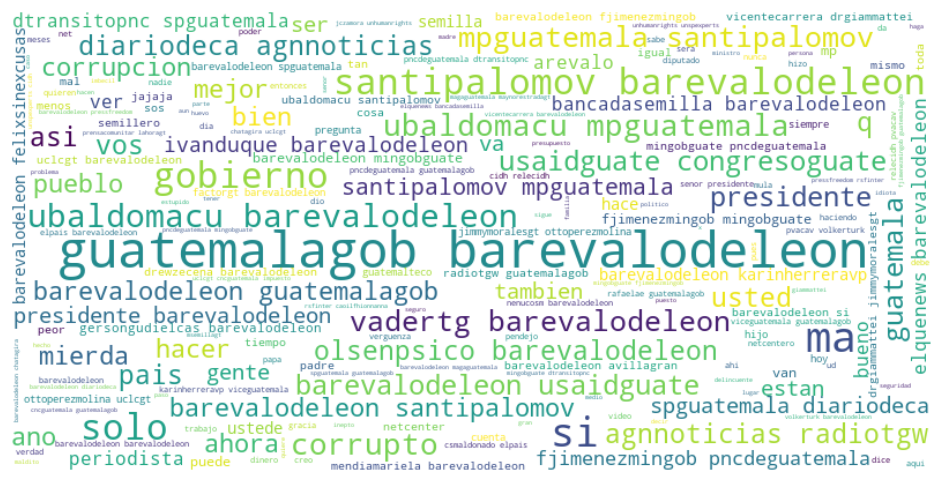

In [22]:
get_word_cloud(df_arevalo, 'processed_text')

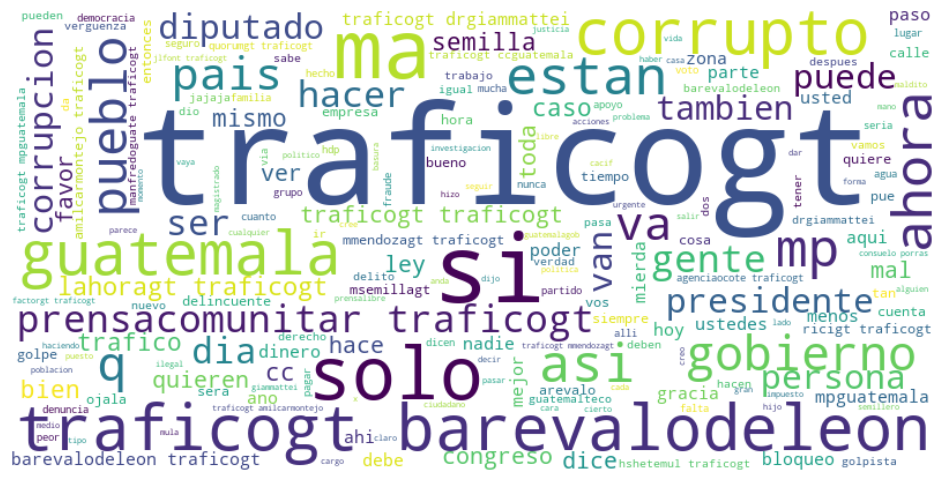

In [23]:
get_word_cloud(df_trafico, 'processed_text')